# Descriptor Function Developments

### Introduction

The purpose of this notebook is to discuss the principles behind the descriptor generating functions used to analyze battery data. It explains the inputs and outputs from the overall package as well as the components that make up the function.

### Installation guidelines

These functions require the following pip installs

```
pip install lmfit
pip install numpy
pip install pandas
pip install peakutils
pip install scipy
```
### Import statements

In [1]:
import sys
sys.path.insert(0, '../chachies')
import descriptors

## Data Generation

Before this package can be used, the following script is used to extract clean separated cycle data from the raw battery data. This can be done using the following code from the `chachifuncs` package.

```
import chachifuncs
chachifuncs.get_all_data(base_folder, raw_data_folder)
```
Where `base_folder` is the path to the folder used for data management and `raw_data_folder` is the folder in `base_folder` that contains the raw battery data. This extracts, cleans, and categorizes raw battery data. It will generate a folder named `Clean_Separated_Cycles`. The path to this folder must be used to run the main function described below.

## Running Main Function

This function generates an excel sheet of descriptors from a folder containing clean cycle data. The python call for this function can be written as follows:

```
import descriptors
descriptors.ML_generate('import_filepath')
```

`import_filepath` must be the directory that contains cleaned cycle ata. The results of the descriptor generation are outputted to an excel spreadsheet titled 'describe.xlsx' in the current directory.

# Components

## Fitting Class

This class contains the function that peform the actual fitting. The process of fitting is represented by the following diagram.

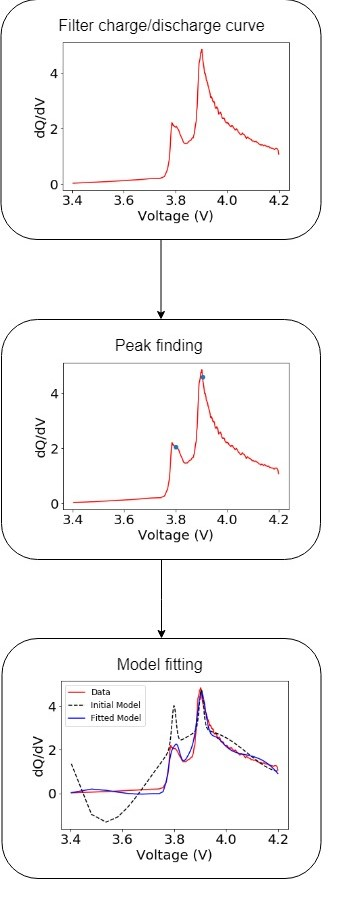

This process is carried out by the `lmfit` package.

### LMfit

lmfit is an open-source fitting platform based on `scipy.optimize.leastsq`. It uses a Levenberg-Marquart algorithm with numerically-calculated derivatives from MINPACK's lmdif function. For our use case. We needed to fit a mixture of Pseudo-Voight distributions with a 4th degree polynomial background. The Pseudo-Voight distribution has the following form:

$$f_v(x,A,\mu,\sigma,\alpha)=\frac{(1−\alpha)A}{\sigma_g \sqrt{2 \pi}}\exp{[−{(x− \mu)}_2/2 {\sigma_g}^2]}+\frac{\alpha A}{\pi}[\frac{\sigma}{{(x-\mu)}^2 + \sigma^2}]$$
$$\sigma_g = \sigma/\sqrt{2 \ln{2}}$$

In this model $A$ is the amplitude of the peak, $\mu$ is the center of the distribution, $\sigma$ and $\alpha$ is the fraction of Lorenzian character.

This function was used to develop and fit $f(x)$ to the following, not linear model:

$$\hat{f}(x) = \sum_{i=0}^{3}\hat{c}_i x^i + \sum_{j=1}^{n}\hat{f}_{vj}(x,\hat{A}_j,\hat{\mu}_j,\hat{\sigma}_j,\hat{\alpha}_j)$$

Where $n$ is the number of peaks determined by the peak fitting function `peak_finder`. The peak finding function uses `peakutils` package.

### Descriptors for ML
The following descriptors were extracted from the each fit for use in the machine leaning component of this package.

Polynomial coefficients:
$$c_0, c_1, c_2, c_3$$

For each peak $j$, the following parameters were used:

$\hat{\mu}_j = $ Peak center

$f(\hat{\mu}_j) = $ Peak height

$\hat{\sigma}_j = $ Peak standard deviation

### Overall Code Use

The overall fit can be obtained using the following:
```
import descriptors

descriptors.fitters.descriptor_func(V_series, dQdV_series, cd, 5, 'battery name')
```

In this function, `V_series` and `dQdV_series` are the pandas series objects for the $x$ and $f(x)$ inputs to the fit. They are generated and used in the function `process.imp_one_cycle`.

`cd` is either 'c' for charge or 'd' for discharge, `5` is the cycle number, and `bat` will contain the battery name. the output of this fuction will be a dictionary containing the descriptors described above.

## Process Class

These functions execute the lmfit peak fitting function and properly organize the pandas dataframe of descriptors. This pandas dataframe has the following form.

In [2]:
import pandas as pd
pd.DataFrame(columns=['names', 'ch_0', 'ch_1', '...', 'ch_18', 'dc_0', 'dc_1', '...', 'dc_18'])

,names,ch_0,ch_1,...,ch_18,dc_0,dc_1,...,dc_18


Each row of the dataframe is an individual cycle. Briefly, each battery cycle is run to develop a dataframe of either charge or discharge data. These dataframes are iteratively conocated vertically and the name of each battery is inserted into the dataset. This process is repeated for the discharge cycles and the charge/discharge dataframes are conocated along the column axis.

### Process class work flow

This call graph was generated on a set of two batteries with 16 cycles total. It shows the structure of the `descriptors` package when `ML_generate` is called.

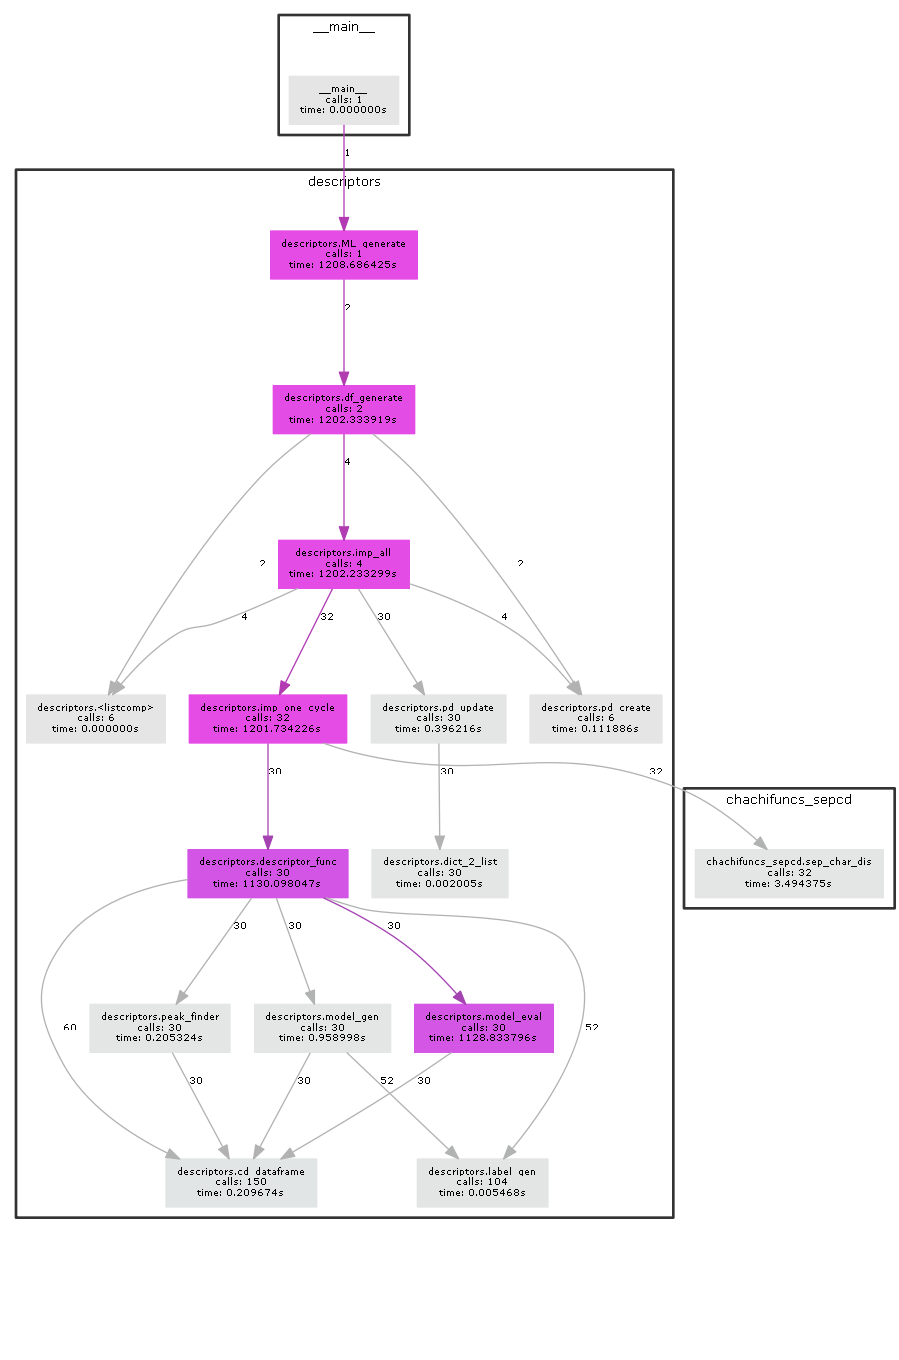

This figure was generated using the package pycallgraph. It can be found at the following GitHub repository: https://github.com/gak/pycallgraph/#python-call-graph

It is installable with the following lines in a python terminal:
```
pip install pycallgraph
pip install graphviz
```

## Descriptor Key

the 'ch_' prefix is for the charge descriptors and will be used in this table as 'pref':

DataFrame Entry | Descriptors
------|------
pref_0 to pref_3 | polynomial coefficient in order of degree
pref_4, 7, 10, ... | peak location (V)
pref_5, 8, 11, ... | peak height (dQ/dV)
pref_6, 9, 12, ... | peak $\sigma$